## **DTSC2301 PROJECT I PART I**
By: AJ Beiza

As a manager for a large department store, a common issue faced is scheduling. Overstaffing leads to unnecessary labor expenses, while understaffing can reduce customer satisfaction and limit profitability. To combat this, we have attempted to model the total amount of hours worked by all employees at an urban department store (target variable PRODTIME). The predictor variables we will use are:

- MONEY, the number of money orders and gift certificates processed 
- MAIL, the number of letter sized mail items 
- WINDOW, the number of window payments transacted 
- CHANGE, the number of change order transactions processed 
- CHECKS, the number of checks cashed 
- MISC, the number of miscellaneous mail items processed on an “as available” basis 
- BUS, the number of bus tickets sold
- DAY, the day of the week

This model can be used to measure the efficiency of a team. For instance, if the model predicts a higher PRODTIME than the actual value, the team was more efficient since they required less hours to do what the model predicted would be required. Using this along with the day of the week, we can understand what days are the least efficient and which days are the most efficient. Our model will be a multiple quadratic regression model, a supervised model that produces a quadratic combination of terms to make a prediction.

Our **assigned** objective is to pick the features that maximize adjusted R^2, which is similar to regular R^2 (a measure of how much variability in target variable is explained by the predictor variables) except that unnecessary predictor variables are penalized, this means that to maximize Radj2, we will have to find the perfect combination of features without using redundant ones. Simply trying to maximize adjusted R^2 is normally not good practice because of sacrifices in overfitting and interpretability.



In [220]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import root_mean_squared_error
from itertools import product

In [221]:
df = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/ProdTime.csv")
print(df.head(3), "\n\n")
df.info()

  day  PRODTIME  MONEY  MAIL  WINDOW  CHANGE  CHECKS  MISC   BUS
0   M     128.5   7781   100     886     235     644    56   737
1   T     113.6   7004   110     962     388     589    57  1029
2   W     146.6   7267    61    1342     398    1081    59   830 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       52 non-null     object 
 1   PRODTIME  52 non-null     float64
 2   MONEY     52 non-null     int64  
 3   MAIL      52 non-null     int64  
 4   WINDOW    52 non-null     int64  
 5   CHANGE    52 non-null     int64  
 6   CHECKS    52 non-null     int64  
 7   MISC      52 non-null     int64  
 8   BUS       52 non-null     int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 3.8+ KB


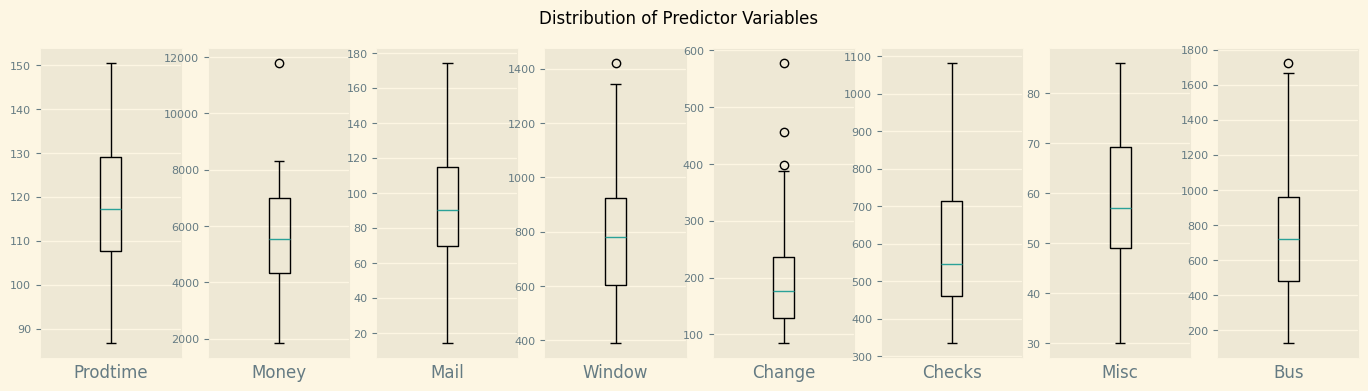

In [222]:
plt.style.use("Solarize_Light2")
plot, axs = plt.subplots(1,8, figsize=(17,4))

for idx, column in enumerate(df.columns[1:]):
    axs[idx].boxplot(df[column])
    axs[idx].set_xlabel(column.title())
    axs[idx].tick_params(axis='both', labelsize=8)
    axs[idx].set_xticks([])

plot.suptitle("Distribution of Predictor Variables")
plt.show()


In [223]:
# adding quadratic terms for all predictor variables to see if they help increase r_2
df["WINDOW_CHECKS"] = df["WINDOW"] * df["CHECKS"] # adding interaction term which increases r^2
for column in df.columns[2:]:
    df[f"{column}_SQUARED"] = df[column]**2


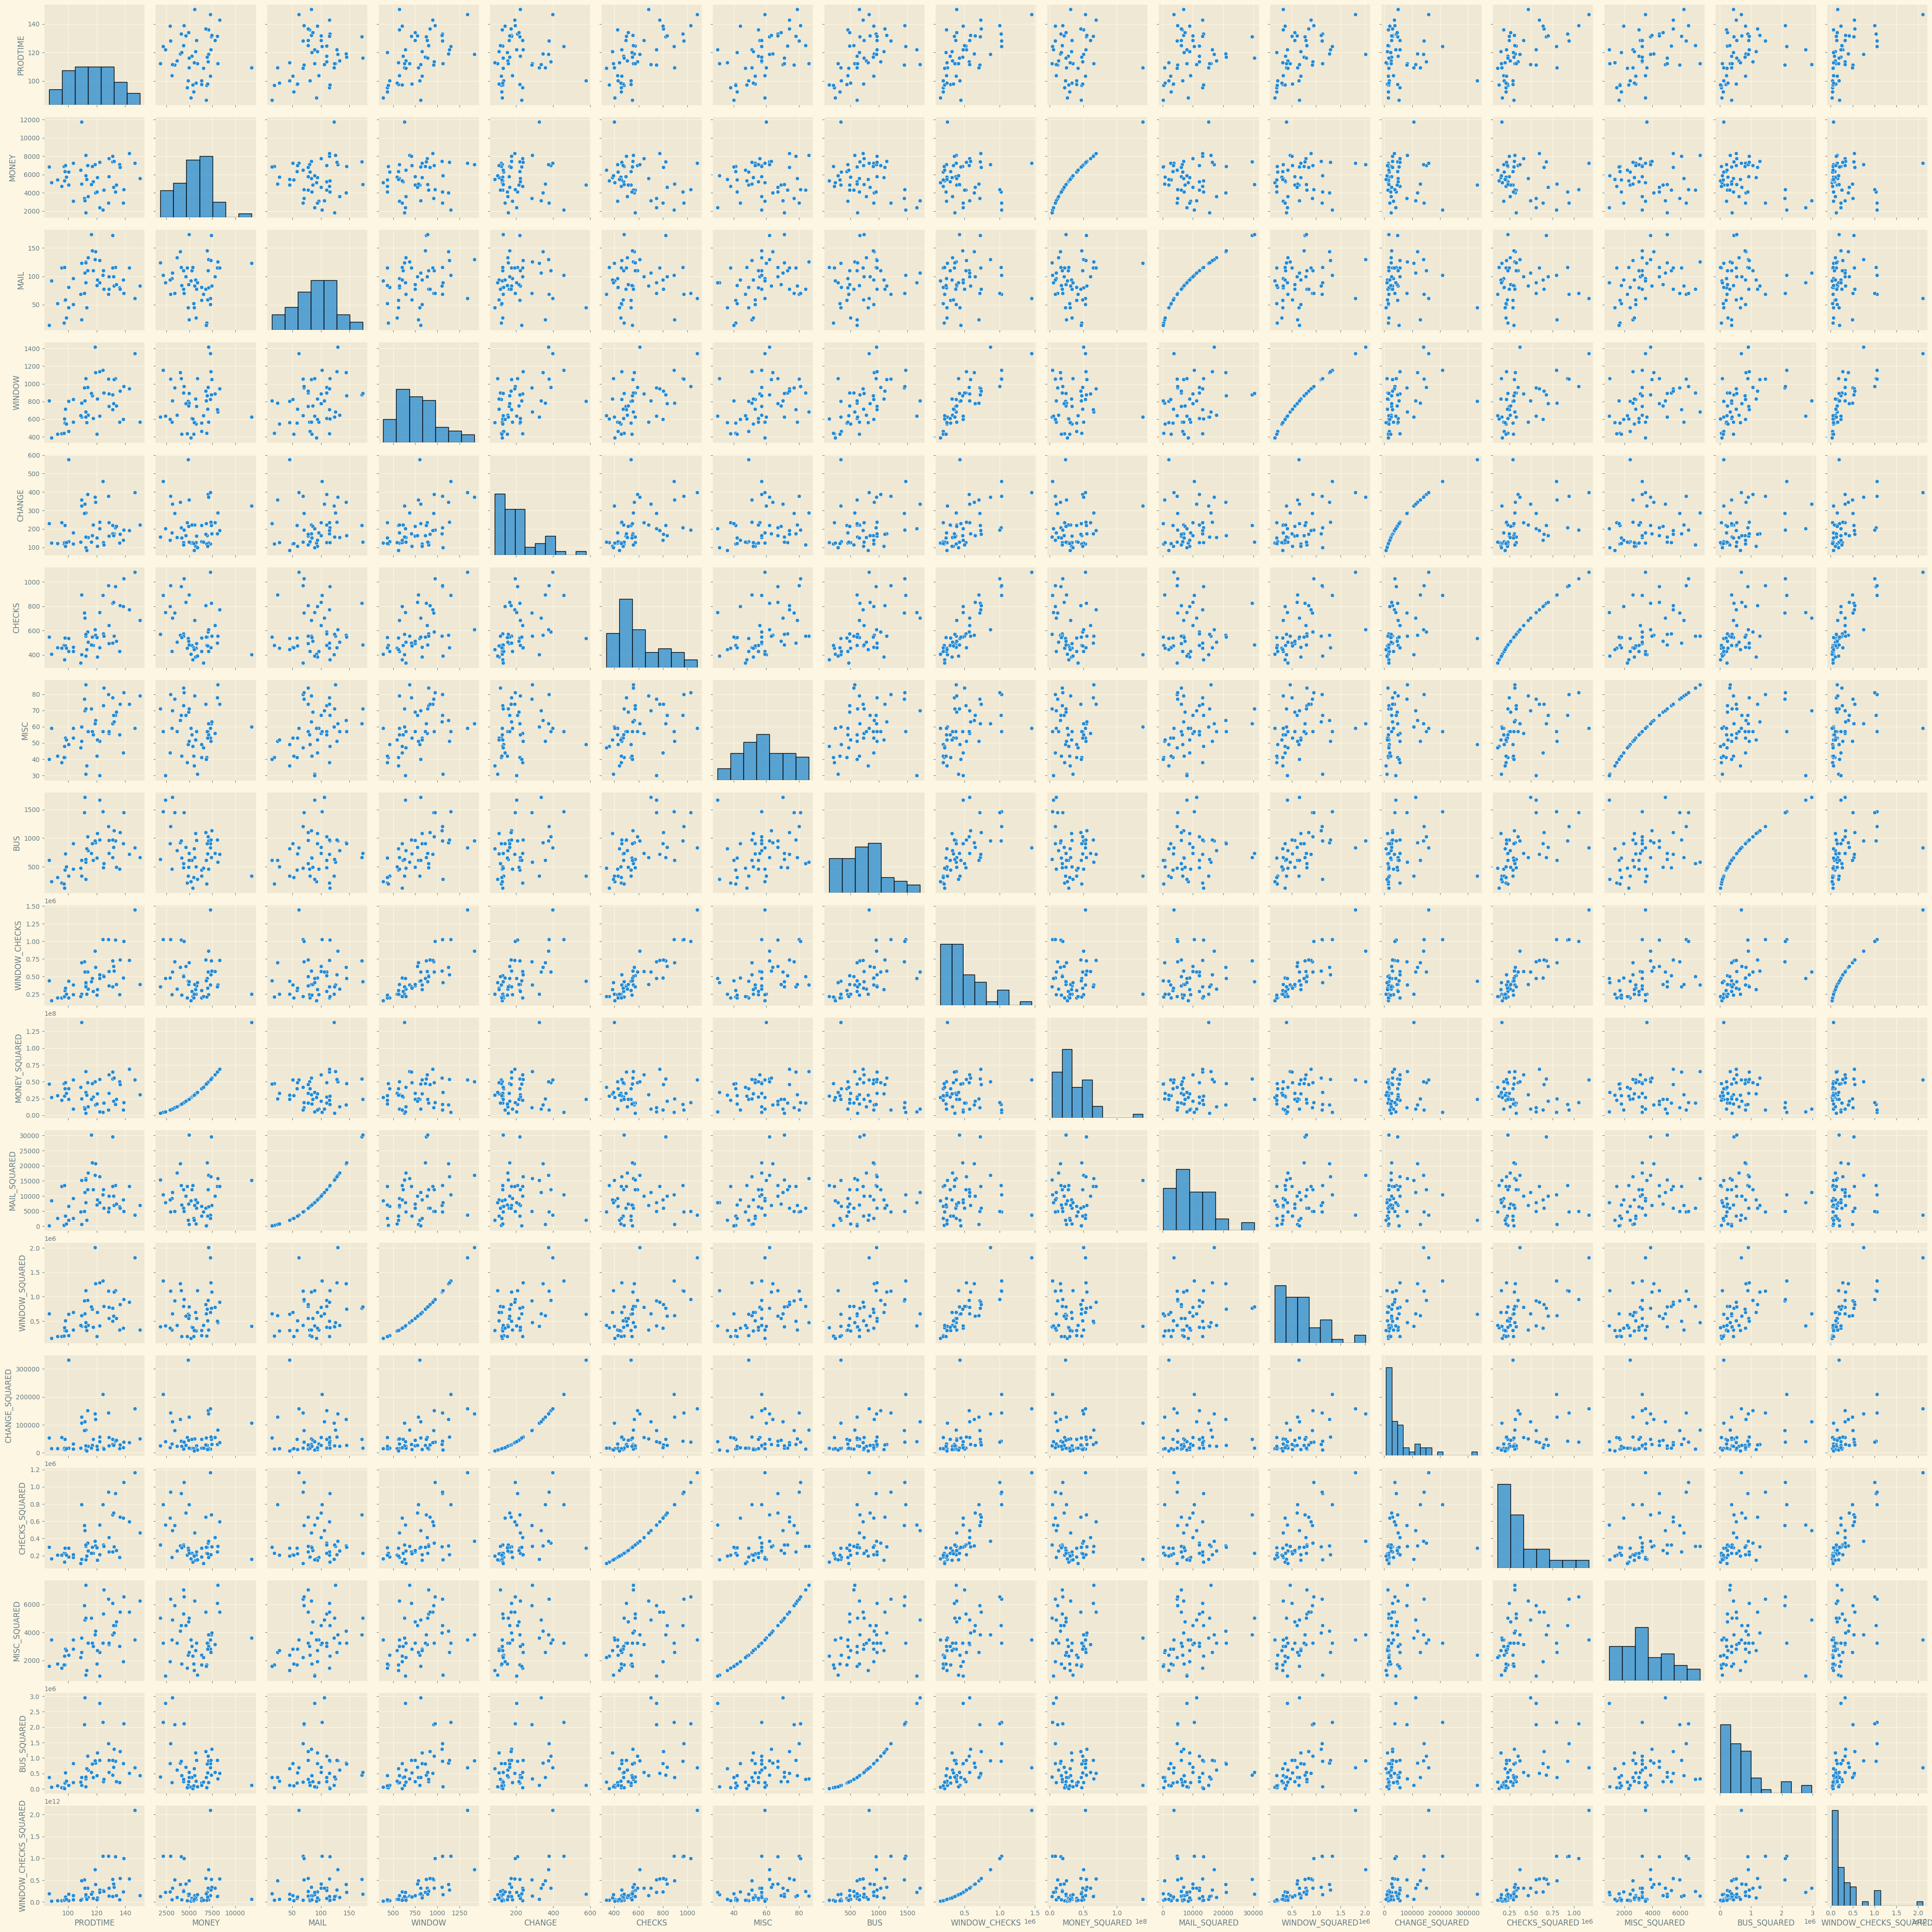

In [224]:
sns.pairplot(df)

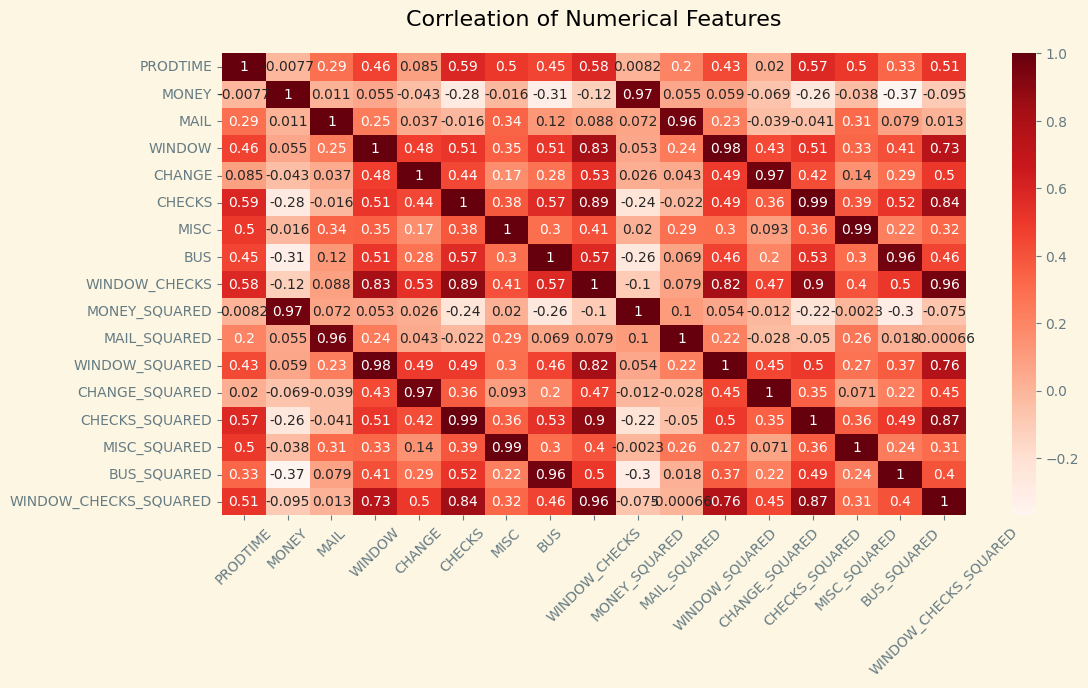

In [225]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), cmap="Reds", annot=True)
plt.title("Corrleation of Numerical Features", pad=20)
plt.xticks(rotation=45)
plt.show()

##### We observe a lot of multicolinearity in the data, but since our only goal is to maximize adjusted R^2, we can ignore this and just take a brute force approach where we try every combination of feature and pick the combination of features that gives the highest adjusted r^2.

In [226]:
# one hot encoding DAY column
df = pd.concat([df, pd.get_dummies(df["day"]).astype("int")], axis=1).drop(columns="day")
df.head(2)

,PRODTIME,MONEY,MAIL,WINDOW,CHANGE,CHECKS,MISC,BUS,WINDOW_CHECKS,MONEY_SQUARED,...,CHECKS_SQUARED,MISC_SQUARED,BUS_SQUARED,WINDOW_CHECKS_SQUARED,F,M,S,T,Th,W
0,128.5,7781,100,886,235,644,56,737,570584,60543961,...,414736,3136,543169,325566101056,0,1,0,0,0,0
1,113.6,7004,110,962,388,589,57,1029,566618,49056016,...,346921,3249,1058841,321055957924,0,0,0,1,0,0


In [227]:
binary_permutations = list(product([0, 1], repeat=16))[1:] # remove first permutation since it is empty list

def filter_features(permutation, columns):
    """
    Filters feature columns by using a binary permutation list. If the ith index in the permutation list
    is one, the ith feature is included into the filtered_features list.
    """
    filtered_features = []
    for i in range(len(permutation)):
        # we either add all the day of the week columns or none
        if i==15 and permutation[i] == 1:
            filtered_features.extend(columns[15:]) # adds all date of week columns
        if permutation[i] == 1:
            filtered_features.append(columns[i])
    return list(set(filtered_features)) # return distinct featutres


X = df.drop(columns=["PRODTIME"])

y = df["PRODTIME"]
max_rsquared = 0 # keeps track of highest r^2 seen
best_model = [] # keeps track of model w/ highest r^2
best_features = [] # keeps track of best features
best_RMSE = np.inf

"""
This is a brute force approach where we try every possible combination 
of features and select the combination that yields the highest
adjusted r^2
"""
for permutation in binary_permutations: 

    features = filter_features(permutation, X.columns)
    filtered_x = sm.add_constant(X[features])

    model = sm.OLS(y, filtered_x).fit()

    # uncomment to select best model based on RMSE
    # y_pred = model.predict(filtered_x)
    # RMSE = root_mean_squared_error(y_true=y, y_pred=y_pred)
    # if RMSE < best_RMSE:
    #     best_model = model
    #     best_features = features

    if model.rsquared_adj > max_rsquared:
        print(model.rsquared_adj) # used to visualize how fast r^2 increases
        max_rsquared = model.rsquared_adj
        best_model = model
        best_features = features


print(max_rsquared)
print(best_features)
best_model.summary()


0.3931048159506171
0.4937659409018903
0.5200463927121693
0.5307329940479848
0.5415144370773108
0.5559151891369339
0.559408124588509
0.5629607300334121
0.5635196583196762
0.5637307017313681
0.5668727128876456
0.567154539464996
0.5853492357032923
0.5947051010946085
0.5957074479897886
0.598930944315787
0.6003946553559723
0.6013665546703011
0.6054187784703772
0.6096418512905248
0.6131154094327201
0.61430696312245
0.6163283399127757
0.6219038375076643
0.6239831784826756
0.6240626206749049
0.6295754895438296
0.6310880285245248
0.6333287973829573
0.6346085763292841
0.6359494039221192
0.641764437027567
0.6510966308878275
0.6515485033612508
0.6591739158489356
0.659661555257091
0.659661555257091
['MONEY', 'MAIL', 'CHANGE', 'WINDOW_CHECKS', 'CHANGE_SQUARED', 'Th', 'WINDOW', 'WINDOW_CHECKS_SQUARED', 'F', 'MISC', 'M', 'W', 'S', 'BUS', 'BUS_SQUARED', 'T', 'CHECKS', 'MAIL_SQUARED']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PRODTIME   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     6.815
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           1.14e-06
Time:                        14:43:28   Log-Likelihood:                -177.36
No. Observations:                  52   AIC:                             390.7
Df Residuals:                      34   BIC:                             425.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -27.4762     32.138     -0.855      0.399     -92.788      37.835
MONEY                     0.0020      0.001      2.124      0.041    8.53e-05       0.004
MAIL                      0.5460      0.184      2.964      0.006       0.172       0.920
CHANGE                   -0.1218      0.065     -1.869      0.070      -0.254       0.011
WINDOW_CHECKS            -0.0003      0.000     -1.918      0.064      -0.001    1.61e-05
CHANGE_SQUARED            0.0002      0.000      1.495      0.144    -5.9e-05       0.000
Th                       -8.5647      5.781     -1.481      0.148     -20.314       3.185
WINDOW                    0.1105      0.056      1.984      0.055      -0.003       0.224
WINDOW_CHECKS_SQUARED  6.734e-11   4.02e-11      1.674      0.103   -1.44e-11    1.49e-10
F                        -5.3945      6.580     -0.820      0.418     -18.767       7.978
MISC                      0.2416      0.135      1.795      0.082      -0.032       0.515
M                        -5.6879      5.894     -0.965      0.341     -17.666       6.290
W                         0.4242      7.237      0.059      0.954     -14.284      15.132
S                        -2.9109      6.499     -0.448      0.657     -16.119      10.297
BUS                       0.0390      0.019      2.069      0.046       0.001       0.077
BUS_SQUARED           -1.913e-05   9.64e-06     -1.985      0.055   -3.87e-05    4.57e-07
T                        -5.3424      6.674     -0.800      0.429     -18.906       8.222
CHECKS                    0.2082      0.081      2.561      0.015       0.043       0.374
MAIL_SQUARED             -0.0026      0.001     -2.678      0.011      -0.005      -0.001
==============================================================================
Omnibus:                        3.759   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.657
Skew:                           0.113   Prob(JB):                        0.161
Kurtosis:                       4.279   Cond. No.                     3.24e+26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.15e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [228]:
y_pred = best_model.predict(sm.add_constant(df[best_features]))
RMSE = root_mean_squared_error(y_true=y, y_pred=y_pred)
print("Root mean squared error of the model is:", RMSE)

Root mean squared error of the model is: 7.329621400022358


In [229]:
residuals = y - y_pred

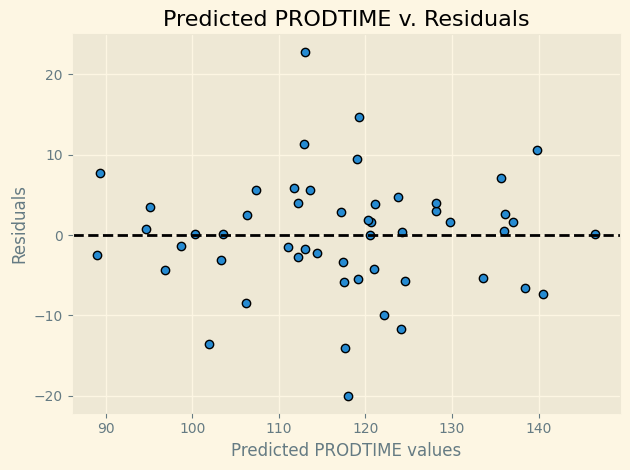

In [230]:
plt.scatter(y_pred, residuals, edgecolors="black")
plt.title("Predicted PRODTIME v. Residuals")
plt.xlabel("Predicted PRODTIME values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

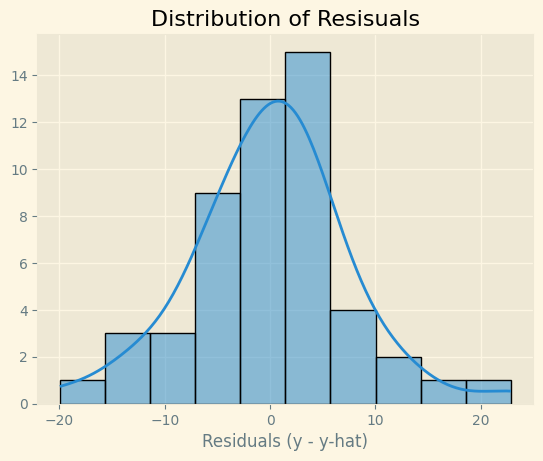

In [231]:
sns.histplot(x=residuals, kde=True) 
plt.title("Distribution of Resisuals")
plt.xlabel("Residuals (y - y-hat)")
plt.ylabel("")
plt.show()